# Rainbow Trout Genome Exploration
This study demonstrates a new method for determining the sex of rainbow trout using genetic information and machine learning.

## Importing necessary packages

In [1]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

%autosave 30

Autosaving every 30 seconds


## Data
The information regarding the data in the paper mentions that the first column is the target column, indication of the gender of the rainbow trout fish.
* Male : 0
* Female : 1

The remaining columns are the SNPs of the rainbow trout. There is a _unified error rate (in %)_ across all SNPs, indicated by the number at the end of the data file's name. A _unified error rate_ across all SNPs means that the same percentage of genotyping errors was applied to every single nucleotide polymorphism (SNP) marker in the dataset.

For the Sim_5 dataset, a 5% unified error rate was used. This means that for each of the 15 SNP markers:
* 5% of the non-missing genotypes were randomly selected to deviate from the ground truth model.
* The same 5% error rate was applied consistently across all 15 SNPs.

Additionally, a few samples with missing SNP information were selected randomly. The missing SNP genotypes were coded as 5.

In [2]:
print("Available Data:")
os.listdir("./data")

Available Data:


['sim_random.dat', 'sim_5.dat', 'sim_real.dat', 'sim_50.dat']

In [8]:
# List of column names
# GN: Gender, M{i}: Marker{i} for i:(1,15)
columnName = ['GN'] + [f'M{i}' for i in range(1,16)]

In [40]:
dataPath = "./data/sim_real.dat"

data = pd.read_csv(dataPath, header = None, sep=',', names=columnName)
# Replacing 5 with np.NaN
data.replace(5, np.nan, inplace=True)
print(f"Shape of data: {data.shape}")
data.head()

Shape of data: (14010, 16)


,GN,M1,M2,M3,M4,M5,M6,M7,M8,M9,M10,M11,M12,M13,M14,M15
0,1,2.0,2.0,2.0,2.0,1.0,2.0,1.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0,1.0
1,1,2.0,2.0,2.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0
2,0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,2.0,2.0,1.0,2.0,1.0,2.0,2.0
3,1,2.0,2.0,2.0,2.0,NaN,2.0,2.0,2.0,NaN,2.0,2.0,1.0,2.0,2.0,1.0
4,1,2.0,NaN,NaN,2.0,1.0,1.0,2.0,1.0,2.0,1.0,2.0,1.0,NaN,NaN,1.0


The data in the markers is represented as follows:
* Heterozygous genotype: Coded as 1
* Homozygous genotype: Coded as 2
* Missing data: Initially coded as 5, then converted to ‘not-a-number’ (nan) during analysis

In genetics, heterozygous and homozygous refer to the genetic composition of an organism for a particular trait or gene.
* An organism is heterozygous when it carries two different alleles (versions) of a gene. Male rainbow trout were assumed to be heterozygous
* An organism is homozygous when it carries two identical alleles of a gene. Female rainbow trout were assumed to be homozygous

In [41]:
print(f"Number of rows with a missing SNP in their sequence: {data[data.isna().any(axis=1)].shape[0]} ")
print(f"Total numer of sequences: {data.shape[0]}\n")
print(f"Ratio to missing sequences: {data[data.isna().any(axis=1)].shape[0]*100/data.shape[0]} %")

Number of rows with a missing SNP in their sequence: 7438 
Total numer of sequences: 14010

Ratio to missing sequences: 53.09064953604568 %


More that 50% of the data samples have atleast one missing SNP.

## Exploring Data

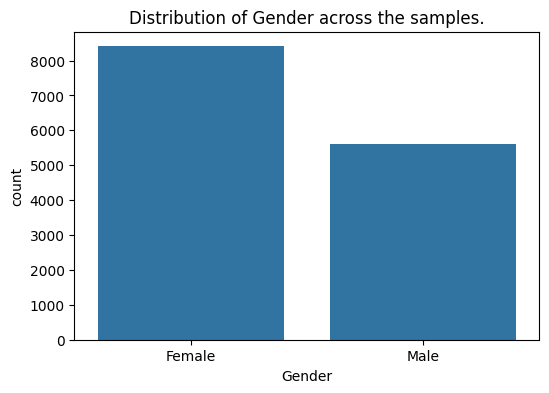

In [28]:
plt.figure(figsize = (6,4), dpi = 100)
sns.barplot(data=data['GN'].replace({1:'Female',0:'Male'}).value_counts())
plt.title("Distribution of Gender across the samples.")
plt.xlabel("Gender")
plt.show()

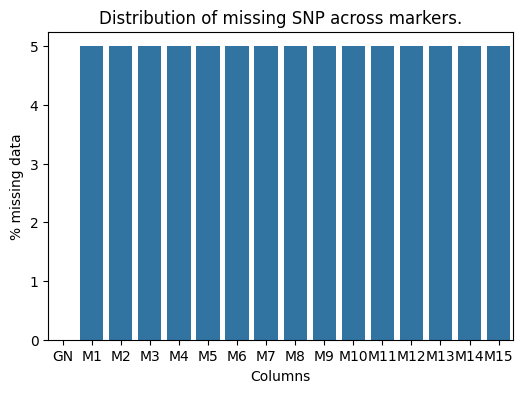

In [49]:
fnx = lambda col : col[col.isna()].shape[0]*100/col.shape[0]
plt.figure(figsize = (6,4), dpi = 100)
sns.barplot(data=data.apply(fnx))
plt.title("Distribution of missing SNP across markers.")
plt.xlabel("Columns")
plt.ylabel("% missing data")
plt.show()

This indicates that about 700 samples per marker was missing among all the samples. This was cross validated with the paper too.

In [111]:
%%time
fnx = lambda row: row.value_counts(normalize=True)
dataCount = data.iloc[:,1:].apply(fnx,axis=1).fillna(0).rename(columns={1:'HETEROZ', 2:'HOMOZ'})
dataCount = dataCount.assign(GENDER = data['GN'])
dataCount['GENDER'] = dataCount['GENDER'].replace({0:'MALE',1:'FEMALE'})
dataCount.head()

CPU times: user 2.52 s, sys: 25.4 ms, total: 2.54 s
Wall time: 2.53 s


,HETEROZ,HOMOZ,GN
0,0.266667,0.733333,FEMALE
1,0.133333,0.866667,FEMALE
2,0.600000,0.400000,MALE
3,0.153846,0.846154,FEMALE
4,0.545455,0.454545,FEMALE


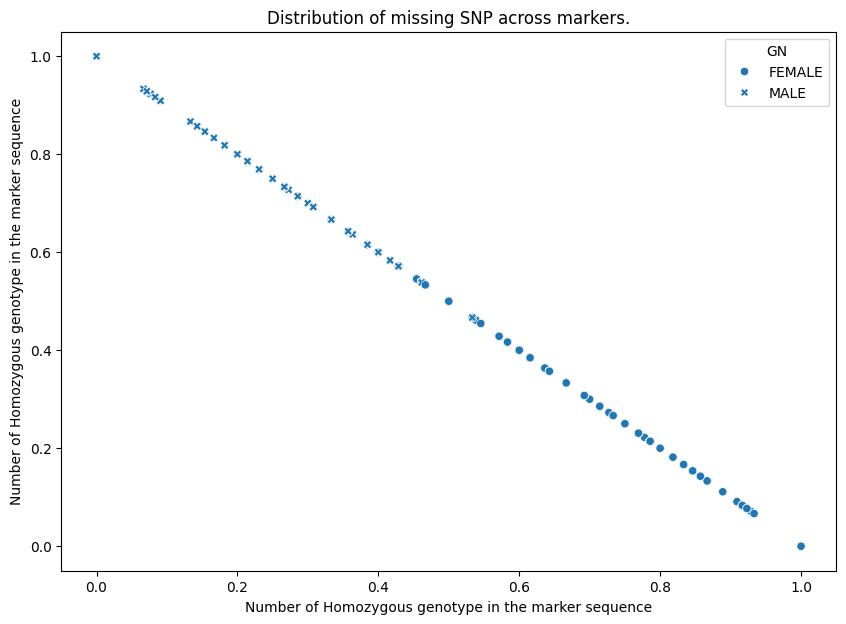

In [112]:
plt.figure(figsize = (10,7), dpi = 100)
sns.scatterplot(data=dataCount, x='HOMOZ', y='HETEROZ', style='GN')
plt.title("Distribution of missing SNP across markers.")
plt.xlabel("Number of Homozygous genotype in the marker sequence")
plt.ylabel("Number of Homozygous genotype in the marker sequence")
plt.show()